To do: 
For each author, show most discriminative features with bars

### Load Context

In [1]:
import os
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

os.chdir("/Users/kipnisal/DS/BiblicalScripts/bib-scripts/")
sys.path.append("/Users/kipnisal/DS/BiblicalScripts/bib-scripts/src")

from kedro.framework.session import KedroSession

with KedroSession.create("biblical_scripts") as session:
    ctx = session.load_context()

params = ctx.params


/usr/local/lib/python3.8/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Mapping
/usr/local/lib/python3.8/site-packages/statsmodels/iolib/foreign.py:651: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/pyth

2021-11-22 10:59:36,483 - kedro.framework.session.store - INFO - `save()` not implemented for `BaseSessionStore`. Skipping the step.


## Aside: add report column to reference_data

In [25]:
import pandas as pd

ref_data = pd.read_csv("data/01_raw/reference_data.csv")

In [26]:
ref_data['to_report'] = True
ref_data.loc[ref_data.author.isin(['Dtr', 'DtrH', 'P']) & (ref_data.index >= 50), 'to_report'] = False

In [27]:
ref_data.to_csv("data/01_raw/reference_data.csv")

# Features

In [2]:
from biblical_scripts.extras.Convert import Convert
from biblical_scripts.pipelines.sim.nodes import build_model

In [3]:
data = ctx.catalog.load("data_proc")
vocab = ctx.catalog.load("vocabulary")
data_raw = ctx.catalog.load('oshb_parsed')

2021-11-22 10:59:36,853 - kedro.io.data_catalog - INFO - Loading data from `data_proc` (CSVDataSet)...
2021-11-22 10:59:37,017 - kedro.io.data_catalog - INFO - Loading data from `vocabulary` (CSVDataSet)...
2021-11-22 10:59:37,031 - kedro.io.data_catalog - INFO - Loading data from `oshb_parsed` (CSVDataSet)...


### Prepare data for each author

In [29]:
md = build_model(data[data.author.isin(params['known_authors'])], vocab, params['model'])
df = md[0].HCT_vs_many()

lo_auth = ["Dtr", "DtrH", "P"]
for auth  in lo_auth :
    df.loc[:,f'{auth}:freq'] =  df[f'{auth}:n'] / df[f'{auth}:T']

df.loc[:,"freq_common"] =  df['n'] / df['T']

dfm = df[df.iloc[:, # only use features selected at least once
                  df.columns.str.contains('affinity')].abs().any(axis=1)].reset_index()

cvr = Convert(data_raw)
dfm['term'] = dfm['feature'].apply(cvr._lem2term)


In [31]:
for auth in lo_auth :
    dfa = dfm.reset_index()\
        .rename(columns = {f'{auth}:pval' : 'pval', f'{auth}:affinity' : 'affinity', f'{auth}:freq' : 'freq'})\
        .filter(['term', 'feature', 'freq', 'pval', 'affinity', 'freq_common'])        
    dfa = dfa.sort_values('pval', ascending=True)
    dfa = dfa[dfa['affinity'] != 0]
    dfa.to_csv(f"/Users/kipnisal/DS/BiblicalScripts/bib-scripts/data/08_reporting/features_{auth}.csv")
    chk = np.mean(2*(dfa['freq'] > dfa['freq_common'])-1 == dfa['affinity'])
    print(f"Affinity check: {chk} (needs to be 1)")
    

Affinity check: 1.0 (needs to be 1)
Affinity check: 1.0 (needs to be 1)
Affinity check: 1.0 (needs to be 1)


In [25]:
dfa

,term,feature,freq,pval,affinity,freq_common,value
15,מְלָכִֽין,4428,0.000497,7.869016e-31,-1.0,0.004001,-69.317205
7,אֲֽשֶׁר,834,0.014195,1.092489e-25,-1.0,0.022104,-57.476169
13,אֱלֹהָֽ/י,430,0.004695,1.066402e-22,-1.0,0.009569,-50.592582
14,לֹ֣א,3808,0.004143,5.159358e-22,-1.0,0.008730,-49.016060
23,זָ֭הָב,2091,0.005413,4.460084e-21,1.0,0.002938,46.859119
...,...,...,...,...,...,...,...
348,נְקֵבָ֥ה,5347,0.000331,3.132905e-02,1.0,0.000168,3.463210
338,שׁוּלֵ֥י,7757,0.000331,3.132905e-02,1.0,0.000168,3.463210
360,רָב֧וּעַ,7251,0.000331,3.132905e-02,1.0,0.000168,3.463210
336,אוֹר,216,0.000331,3.132905e-02,1.0,0.000168,3.463210


#### Plot

/usr/local/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1428 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1433 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1443 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1453 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1445 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1444 missing from current font.
/usr/local/lib/python3

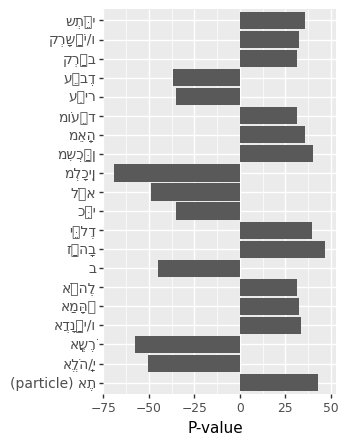

/usr/local/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1443 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1453 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1425 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1445 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1448 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1433 missing from current font.


<ggplot: (355984674)>


/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1428 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 1443 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 1453 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 1425 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 1445 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 1448 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 1433 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_ag

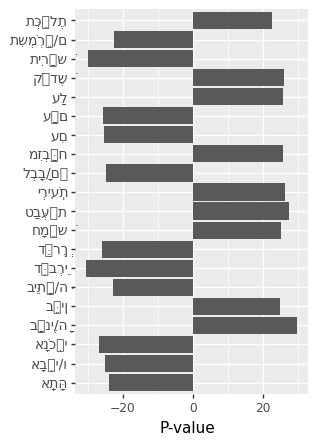

<ggplot: (355966618)>


/usr/local/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1430 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1425 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1443 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1434 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1437 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1431 missing from current font.
/usr/local/lib/python3

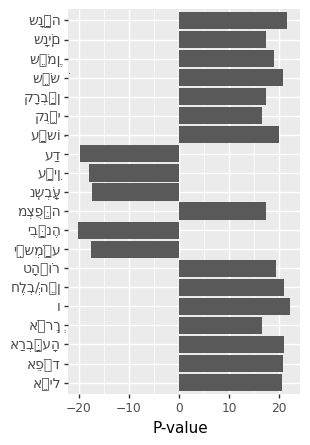

<ggplot: (355984755)>


/usr/local/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1453 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1444 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1443 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1425 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1431 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1445 missing from current font.
/usr/local/lib/python3

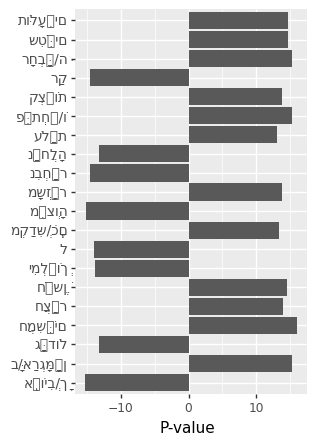

<ggplot: (357034599)>


/usr/local/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1445 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1429 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1425 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1430 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1443 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1437 missing from current font.
/usr/local/lib/python3

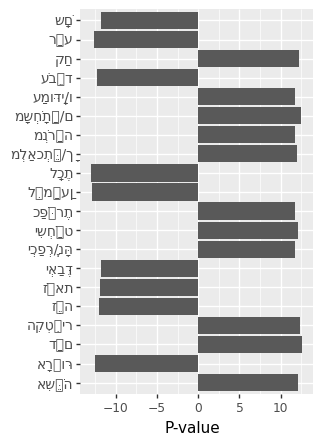

/usr/local/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1443 missing from current font.


<ggplot: (355978768)>


/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1453 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1437 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1431 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1445 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1430 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1444 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1433 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_ag

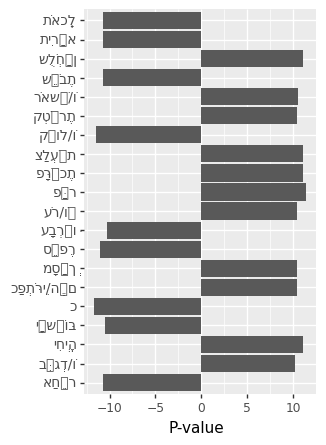

<ggplot: (357093389)>


/usr/local/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1453 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1425 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1443 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1438 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1428 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1431 missing from current font.
/usr/local/lib/python3

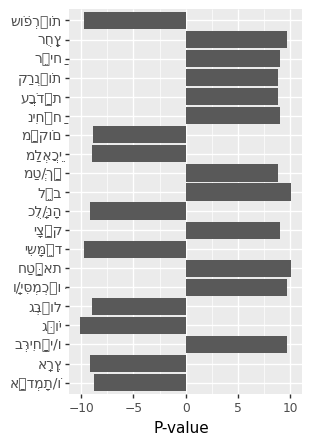

<ggplot: (357007601)>


/usr/local/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1429 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1445 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1443 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1430 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1425 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1431 missing from current font.
/usr/local/lib/python3

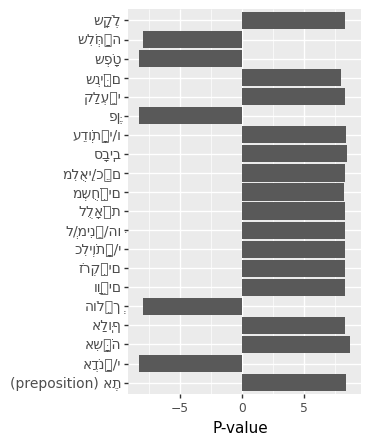

<ggplot: (356974210)>


/usr/local/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1430 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1431 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1444 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1428 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1443 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1425 missing from current font.
/usr/local/lib/python3

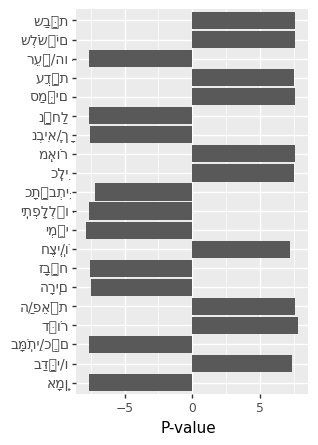

<ggplot: (356999921)>


/usr/local/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1443 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1437 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1431 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1445 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1448 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1430 missing from current font.
/usr/local/lib/python3

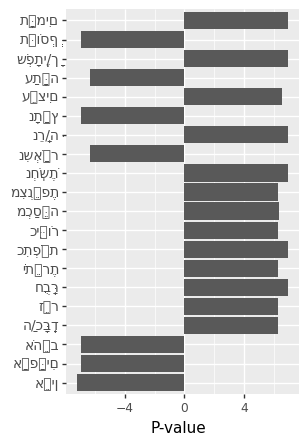

<ggplot: (355776058)>


/usr/local/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1430 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1445 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1428 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1425 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1444 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1443 missing from current font.
/usr/local/lib/python3

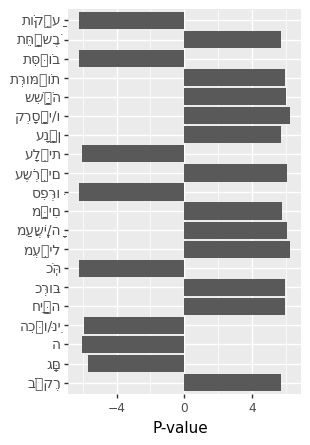

<ggplot: (355783882)>


/usr/local/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1425 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1430 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1443 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1433 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1445 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1453 missing from current font.
/usr/local/lib/python3

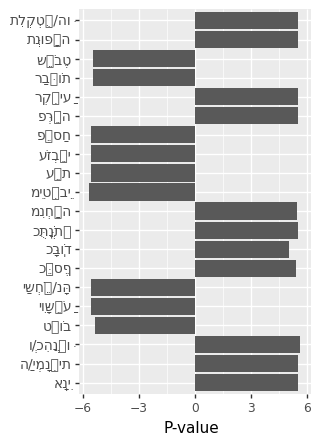

<ggplot: (356978716)>


/usr/local/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1425 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1430 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1443 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1445 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1431 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1437 missing from current font.
/usr/local/lib/python3

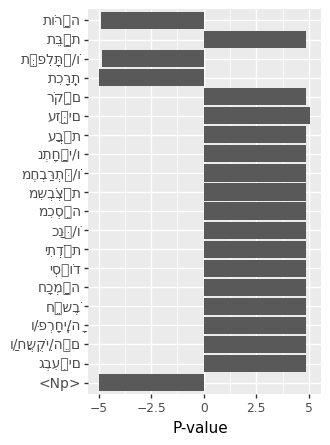

<ggplot: (356931976)>


/usr/local/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1443 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1433 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1445 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1425 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 1443 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 1433 missing from current font.
/usr/local/lib/python3

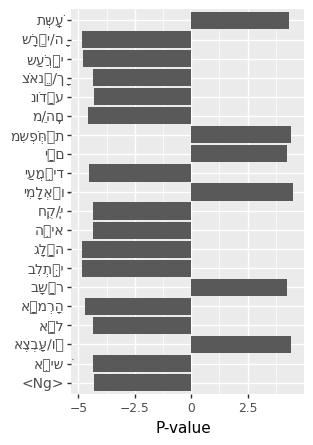

<ggplot: (355783876)>


/usr/local/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1428 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1443 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1445 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1430 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1425 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1453 missing from current font.
/usr/local/lib/python3

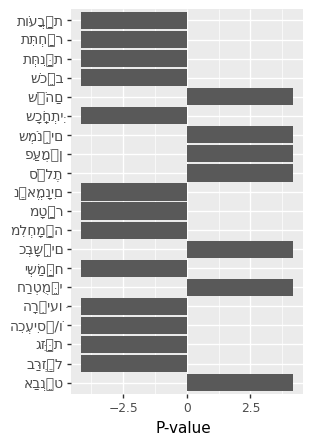

<ggplot: (355777383)>


/usr/local/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1425 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1445 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1430 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1451 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1443 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 1425 missing from current font.
/usr/local/lib/python3

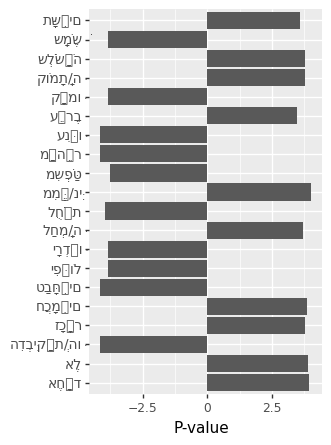

<ggplot: (356400818)>


/usr/local/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1430 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1445 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1425 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1428 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1431 missing from current font.
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1451 missing from current font.
/usr/local/lib/python3

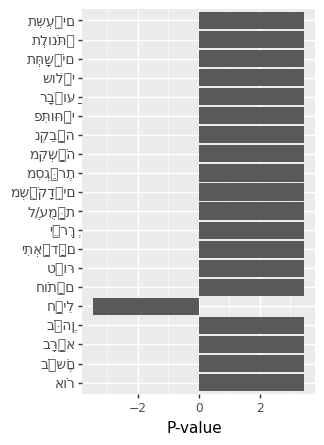

<ggplot: (347192194)>


In [28]:
import plotnine
plotnine.options.figure_size = (3, 5)
from plotnine import *
LIST_OF_COLORS = ['tab:red', 'tab:blue','tab:gray', "#00BA38", 
    'tab:olive', "#619CFF", 'tab:orange', "#F8766D",
    'tab:purple', 'tab:brown', 'tab:pink',
    'tab:green', 'tab:cyan', 'royalblue', 'darksaltgray', 'forestgreen',
    'cyan', 'navy'
    'magenta', '#595959', 'lightseagreen', 'orangered', 'crimson'
]

k = 60   # number of words to consider per author

lo_words = dfa['term'].tolist()
feature_cat = pd.Categorical(dfa['term'], categories = lo_words[::-1])

dfs = dfa.assign(feature_cat = feature_cat)

dfa['value'] = -np.log(dfa['pval']) * dfa['affinity']
M = 20
L = len(dfa) // M 

for i in range(L) :
    df1 = dfa.iloc[i*M:(i+1)*M,:]
    p = (ggplot(aes(x = 'term', y = 'value'), data=df1) + 
             geom_bar(position='dodge', stat="identity", 
                      show_legend=False, size=.5) +
             scale_color_manual(values = LIST_OF_COLORS) +
             coord_flip() + 
             ylab('P-value') +
             xlab('') +
             scale_x_discrete() +
             theme(legend_position='top', 
                legend_title=element_blank(),
                legend_text=element_text(size=12),
                axis_text_y=element_text(size=10)
                    )

            )
    #p.save(f"word_freq_table_exm_{i}.png")
    print(p)



In [196]:
import re
lemma = "m/854"
lemma = "m/853"
if re.findall(r"\b854\b", lemma) :
    print('(preposition) אֶת')
if re.findall(r"\b853\b", lemma) :
    print('(particle) אֶת')


(particle) אֶת


In [194]:
data_raw[data_raw.lemma.str.contains(r"\b853\b")].head(40)

,chapter,lemma,morph,term,verse,author
20,1Chr.10,853,HTo,אֶת,1Chr.10.2,"1, 1 Chron 10"
22,1Chr.10,c/853,HC/To,וְ/אֶת,1Chr.10.2,"1, 1 Chron 10"
24,1Chr.10,c/853,HC/To,וְ/אֶת,1Chr.10.2,"1, 1 Chron 10"
63,1Chr.10,853,HTo,אֶת,1Chr.10.4,"1, 1 Chron 10"
111,1Chr.10,853,HTo,אֶת,1Chr.10.8,"1, 1 Chron 10"
114,1Chr.10,853,HTo,אֶת,1Chr.10.8,"1, 1 Chron 10"
116,1Chr.10,c/853,HC/To,וְ/אֶת,1Chr.10.8,"1, 1 Chron 10"
123,1Chr.10,853,HTo,אֶת,1Chr.10.9,"1, 1 Chron 10"
125,1Chr.10,c/853,HC/To,וְ/אֶת,1Chr.10.9,"1, 1 Chron 10"
132,1Chr.10,853,HTo,אֶת,1Chr.10.9,"1, 1 Chron 10"


In [168]:
data_raw

,chapter,lemma,morph,term,verse,author
0,1Chr.10,c/6430,HC/Ngmpa,וּ/פְלִשְׁתִּ֖ים,1Chr.10.1,"1, 1 Chron 10"
1,1Chr.10,3898 a,HVNp3cp,נִלְחֲמ֣וּ,1Chr.10.1,"1, 1 Chron 10"
2,1Chr.10,b/3478,HR/Np,בְ/יִשְׂרָאֵ֑ל,1Chr.10.1,"1, 1 Chron 10"
3,1Chr.10,c/5127,HC/Vqw3ms,וַ/יָּ֑נָס,1Chr.10.1,"1, 1 Chron 10"
4,1Chr.10,376,HNcmsc,אִֽישׁ,1Chr.10.1,"1, 1 Chron 10"
...,...,...,...,...,...,...
63347,Prov.31,m/6529,HR/Ncmsc,מִ/פְּרִ֣י,Prov.31.31,Prov
63348,Prov.31,3027,HNcbdc/Sp3fs,יָדֶ֑י/הָ,Prov.31.31,Prov
63349,Prov.31,c/1984 b,HC/Vpi3mp/Sp3fs,וִֽ/יהַלְל֖וּ/הָ,Prov.31.31,Prov
63350,Prov.31,b/8179,HRd/Ncmpa,בַ/שְּׁעָרִ֣ים,Prov.31.31,Prov


In [94]:
dfs

,feature,n,T,Dtr:n,Dtr:T,DtrH:n,DtrH:T,P:n,P:T,affinity,pval,DtrH:affinity,DtrH:pval,P:affinity,P:pval,Dtr:freq,DtrH:freq,P:freq,feature_cat,value
0,430,342,35740,187,8209,70,9426,85,18105,1.0,1.583875e-37,-1.0,1.691140e-02,-1.0,1.066402e-22,0.022780,0.007426,0.004695,8085,84.735774
1,3808,312,35740,153,8209,84,9426,75,18105,1.0,3.013310e-24,0.0,8.471689e-01,-1.0,5.159358e-22,0.018638,0.008912,0.004143,312,54.159003
2,b,1309,35740,433,8209,373,9426,503,18105,1.0,2.549655e-18,0.0,7.350375e-02,-1.0,3.574126e-20,0.052747,0.039571,0.027782,176,40.510574
3,<Np>,2448,35740,390,8209,881,9426,1177,18105,-1.0,1.147150e-17,1.0,1.121359e-29,-1.0,6.745022e-03,0.047509,0.093465,0.065010,5707,-39.006666
4,834,790,35740,281,8209,252,9426,257,18105,1.0,1.591953e-16,1.0,3.321767e-04,-1.0,1.092489e-25,0.034231,0.026735,0.014195,1616,36.376400
5,398,71,35740,47,8209,6,9426,18,18105,1.0,9.586809e-15,-1.0,1.387934e-03,-1.0,2.222828e-05,0.005725,0.000637,0.000994,6963,32.278388
6,3423,50,35740,36,8209,13,9426,1,18105,1.0,2.489329e-13,-0.0,1.000000e+00,-1.0,1.129294e-13,0.004385,0.001379,0.000055,168,29.021593
7,595,40,35740,31,8209,9,9426,0,18105,1.0,4.137426e-13,-0.0,7.201604e-01,-1.0,2.115526e-12,0.003776,0.000955,0.000000,413,28.513532
8,l,2111,35740,611,8209,537,9426,963,18105,1.0,7.412118e-12,-0.0,3.236198e-01,-1.0,9.463070e-07,0.074431,0.056970,0.053190,4908,25.627905
9,4687,43,35740,31,8209,7,9426,5,18105,1.0,1.098648e-11,-0.0,2.255320e-01,-1.0,2.767681e-07,0.003776,0.000743,0.000276,520,25.234356


In [84]:
dfs['value']

0     1.583875e-37
1     3.013310e-24
2     2.549655e-18
3    -1.147150e-17
4     1.591953e-16
5     9.586809e-15
6     2.489329e-13
7     4.137426e-13
8     7.412118e-12
9     1.098648e-11
10   -1.846787e-11
11    2.352119e-11
12    3.997105e-11
13    4.569030e-11
14   -2.056796e-09
15    1.316841e-08
16    1.726168e-08
17    1.726168e-08
18    2.126938e-08
19   -2.413427e-08
20    1.011609e-07
21    1.047148e-07
22    2.180160e-07
23    3.729539e-07
24   -7.529127e-07
25    1.532675e-06
26    1.924195e-06
27    2.079682e-06
28    3.525172e-06
29    3.913052e-06
30   -4.334328e-06
31    4.465602e-06
32    4.518714e-06
33    4.718157e-06
34    5.302598e-06
35    7.100972e-06
36    1.027217e-05
37    1.242990e-05
38    1.401353e-05
39    1.626821e-05
40    1.675272e-05
41   -1.839597e-05
42   -1.922984e-05
43    2.214414e-05
44   -2.980960e-05
45    3.357005e-05
46    3.357005e-05
47    3.801752e-05
48   -4.110162e-05
49   -4.884750e-05
50   -6.971160e-05
51   -9.932301e-05
52   -1.0721